In [4]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler

In [5]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(100),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
data_dir = 'dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

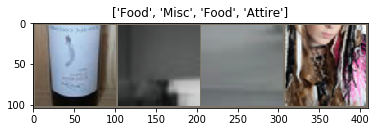

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
# https://www.kaggle.com/usingtc/lenet-with-pytorch

In [11]:
import torch.nn.functional as F

I have resized my images to 100 X 100

https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py

In [12]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# help(nn.Conv2d)

In [14]:
num_epochs = 5
num_classes = 4
# batch_size = 100
learning_rate = 0.001

In [16]:
model = AlexNet(num_classes).to(device)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
import time
import copy

In [21]:
from torchsummary import summary

https://discuss.pytorch.org/t/what-is-adaptiveavgpool2d/26897

https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d

In [22]:
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]          23,296
              ReLU-2           [-1, 64, 24, 24]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         590,080
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

In [24]:
model_conv = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3318 Acc: 0.3741
val Loss: 1.3180 Acc: 0.3806

Epoch 1/24
----------
train Loss: 1.3204 Acc: 0.3791
val Loss: 1.3229 Acc: 0.3806

Epoch 2/24
----------
train Loss: 1.3171 Acc: 0.3808
val Loss: 1.3140 Acc: 0.3806

Epoch 3/24
----------
train Loss: 1.3169 Acc: 0.3808
val Loss: 1.3134 Acc: 0.3806

Epoch 4/24
----------
train Loss: 1.3164 Acc: 0.3808
val Loss: 1.3133 Acc: 0.3806

Epoch 5/24
----------
train Loss: 1.3161 Acc: 0.3808
val Loss: 1.3134 Acc: 0.3806

Epoch 6/24
----------


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/lonewolf/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/lonewolf/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/lonewolf/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/lonewolf/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Model is behaving better than lenet terrible, but still useless, would train on colab